In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras import layers, optimizers, models
from keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dataset

In [2]:
labels = os.listdir('fruits-360/Training')
labels.sort()
print('Il dataset contiene %i classi di frutta: ' %(len(labels)))
print(labels)

Il dataset contiene 131 classi di frutta: 
['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 

### Load and split the dataset into Training (80%) and Validation (20%) dataset

In [3]:
batch_size = 512

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split = 0.2,
)

train = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset = 'training',
    seed = 42,
)

validation = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset = 'validation',
    seed = 42,
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.


### Load the Test dataset

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

test = train_datagen.flow_from_directory(
    'fruits-360/Test',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
)

Found 22688 images belonging to 131 classes.


### Some fruits exaple

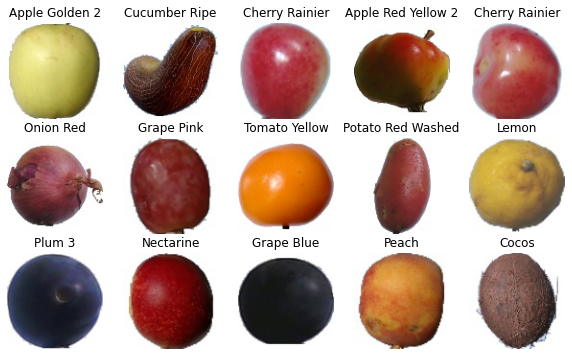

In [5]:
plot_x, plot_y = next(train)
train.reset()
_ , axs = plt.subplots(3,5, figsize = (10,6))
for i, ax in enumerate(axs.ravel()):
    index = np.random.randint(0, plot_x.shape[0])
    ax.imshow(plot_x[index])
    ax.set_title(labels[np.argmax(plot_y[index])])
    ax.axis('off')

# Convolutional Neural Network

In [6]:
model = Sequential()
model.add(layers.Input(shape = (100,100,3)))

model.add(layers.Conv2D(16, 10, activation = 'swish', padding = 'same', name = "Conv2D_1"))
model.add(layers.AveragePooling2D(2, name = "Pooling_1"))
model.add(layers.Dropout(0.3, name = "Dropout_1"))

model.add(layers.Conv2D(16, 10, activation = 'swish', padding = 'same', name = "Conv2D_2"))
model.add(layers.AveragePooling2D(2, name = "Pooling_2"))
model.add(layers.Dropout(0.3, name = "Dropout_2"))

model.add(layers.Conv2D(16, 10, activation = 'swish', padding = 'same', name = "Conv2D_3"))
model.add(layers.AveragePooling2D(2, name = "Pooling_3"))
model.add(layers.Dropout(0.3, name = "Dropout_3"))

model.add(layers.Flatten())
model.add(layers.Dense(131, activation = "softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.compile(optimizer = optimizers.Adam(learning_rate=0.0001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 100, 100, 16)      4816      
_________________________________________________________________
Pooling_1 (AveragePooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 50, 50, 16)        25616     
_________________________________________________________________
Pooling_2 (AveragePooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
Dropout_2 (Dropout)          (None, 25, 25, 16)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 25, 25, 16)        2

In [7]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
]

In [8]:
history = model.fit(
    train,
    epochs = 500,
    validation_data = validation,
    steps_per_epoch = len(train),
    validation_steps = len(validation),
    callbacks = my_callbacks,
)

Epoch 1/500
106/106 [==============================] - 25s 234ms/step - loss: 6.1757 - accuracy: 0.0862 - val_loss: 4.1927 - val_accuracy: 0.3879
Epoch 2/500
106/106 [==============================] - 24s 228ms/step - loss: 3.4421 - accuracy: 0.4842 - val_loss: 2.4823 - val_accuracy: 0.7734
Epoch 3/500
106/106 [==============================] - 24s 231ms/step - loss: 2.3163 - accuracy: 0.7228 - val_loss: 1.8955 - val_accuracy: 0.8605
Epoch 4/500
106/106 [==============================] - 25s 233ms/step - loss: 1.7862 - accuracy: 0.8255 - val_loss: 1.5955 - val_accuracy: 0.8799
Epoch 5/500
106/106 [==============================] - 24s 229ms/step - loss: 1.4627 - accuracy: 0.8781 - val_loss: 1.3753 - val_accuracy: 0.9048
Epoch 6/500
106/106 [==============================] - 24s 224ms/step - loss: 1.2356 - accuracy: 0.9080 - val_loss: 1.2041 - val_accuracy: 0.9212
Epoch 7/500
106/106 [==============================] - 24s 223ms/step - loss: 1.0574 - accuracy: 0.9302 - val_loss: 1.0719 -

### Visualize the loss function and the accuracy through the training

In [9]:
print('Informations stored in hystory:')
for key in history.history.keys():
    print(key)

Informations stored in hystory:
loss
accuracy
val_loss
val_accuracy


Text(0.5, 1.0, 'Loss')

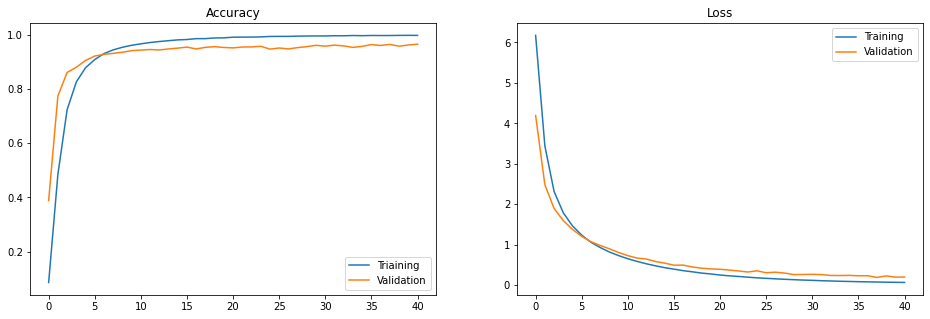

In [10]:
_ , ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(history.history['accuracy'], label = 'Triaining')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].legend()
ax[1].set_title('Loss')

### Evaluate the model on the Test Dataset

In [11]:
score = model.evaluate(test, steps = len(test))

45/45 [==============================] - 9s 202ms/step - loss: 0.2528 - accuracy: 0.9588


In [12]:
print('**********************************')
print('* Acurracy of the model = %s%s *' %(round(100*score[1],2), "%"))
print('**********************************')

**********************************
* Acurracy of the model = 95.88% *
**********************************


In [21]:
#model.save('cnn.h5')
model = tf.keras.models.load_model('cnn.h5')

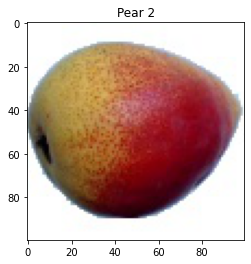

In [28]:
fig, lab = next(test)
indx = np.random.randint(0,batch_size)
fig, lab = fig[indx], lab[indx]
plt.imshow(fig)
plt.title(labels[np.argmax(lab)])
plt.show()
fig = np.expand_dims(fig, axis = 0)
fig.shape

In [30]:

layers_outputs = [layer.output for layer in model.layers[:9]]
activation_model = models.Model(inputs = model.input, outputs = layers_outputs)
activation = activation_model.predict(fig)

In [31]:
images_per_rows = 8
layer_names = []
for layer in model.layers[:9]:
    layer_names.append(layer.name)
print(layer_names)

['Conv2D_1', 'Pooling_1', 'Dropout_1', 'Conv2D_2', 'Pooling_2', 'Dropout_2', 'Conv2D_3', 'Pooling_3', 'Dropout_3']


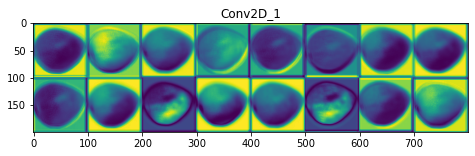

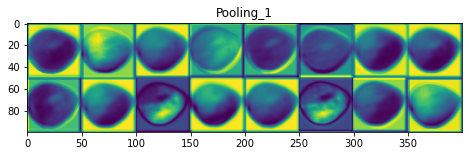

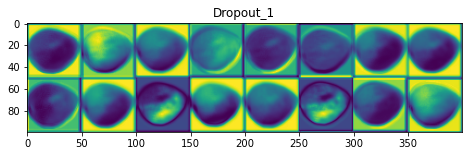

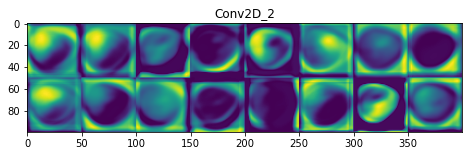

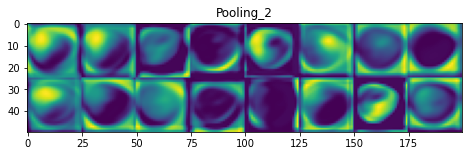

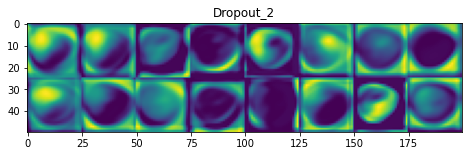

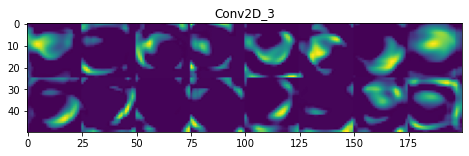

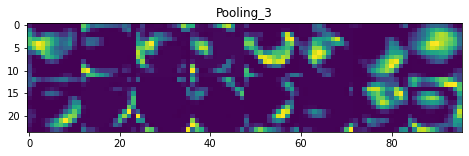

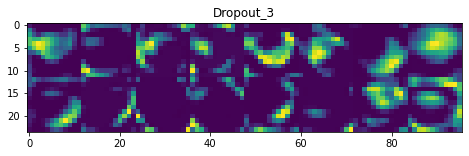

In [32]:
for layer_name, layer_activation in zip(layer_names,activation):
    
    n_filters = layer_activation.shape[-1] #numero di filtri applicati nel livello
    size = layer_activation.shape[1] #lato dell' "immagine"
    n_rows = n_filters // images_per_rows #numero di righe che avrà la griglia con le immagini
    
    img_grid = np.zeros((size * n_rows, images_per_rows * size))
    
    for row in range(n_rows):
        for i in range(images_per_rows):
            image = layer_activation[0, :, :, row * images_per_rows + i]
            
            #rescaling dei dati in un intervallo [0,255], facoltativo per avere una migliore visione
            image = (image - np.amax(image))/(np.amax(image)-np.amin(image))
            image *= 255

            img_grid[row * size : (row + 1) * size, i * size : (i + 1) * size] = image
    
    scale = 1. / size
    plt.figure(figsize = (scale * img_grid.shape[1], scale * img_grid.shape[0]))
    plt.title(layer_name)
    plt.imshow(img_grid)
                    

# PCA and Decision Tree

In [70]:
number_of_images = 40000
number_of_test = 3000
risoluzione = 32

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

train = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(risoluzione, risoluzione),
    color_mode='rgb',
    batch_size=number_of_images,
    class_mode='categorical',
    shuffle = True,
    seed = 42,
)

test = train_datagen.flow_from_directory(
    'fruits-360/Test',
    target_size=(risoluzione, risoluzione),
    color_mode='rgb',
    batch_size=number_of_test,
    class_mode='categorical',
    shuffle = True,
    seed = 42,
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [71]:
x , y = next(train)
x_test, y_test = next(test)
print(x.shape)
print(x_test.shape)

(40000, 32, 32, 3)
(3000, 32, 32, 3)


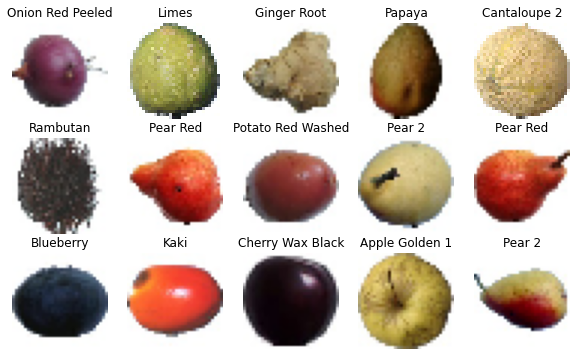

In [72]:
_ , axs = plt.subplots(3,5, figsize = (10,6))
for i, ax in enumerate(axs.ravel()):
    index = np.random.randint(0, x.shape[0])
    ax.imshow(x[index])
    ax.set_title(labels[np.argmax(y[index])])
    ax.axis('off')

Text(0.5, 1.0, 'Test')

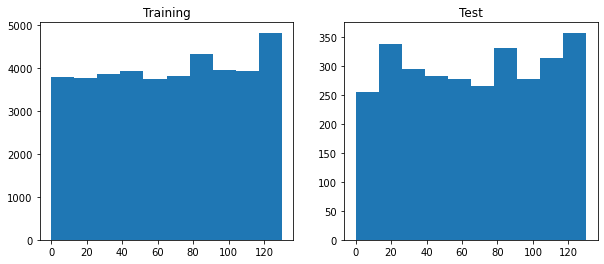

In [73]:
_, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].hist(np.argmax(y, axis = 1))
axs[0].set_title('Training')
axs[1].hist(np.argmax(y_test, axis = 1))
axs[1].set_title('Test')

### Dimension reduction using PCA

In [74]:
scaler = StandardScaler()
x = scaler.fit_transform([i.flatten() for i in x])
x.shape

(40000, 3072)

In [75]:
#Costoso computazionalmente, caricare direttamente il modello già salvato.
#pca = PCA(n_components = 0.95)
#pca = pca.fit(x)
#dump(pca, 'pca.joblib')
pca = load('pca.joblib')

In [76]:
x_reduced = pca.transform(x)
print(x_reduced.shape)

(40000, 313)


In [77]:
scaler = StandardScaler()
x_test = scaler.fit_transform([i.flatten() for i in x_test])
x_test.shape
x_test = pca.transform(x_test)

### Decision Tree

In [78]:
classifier = tree.DecisionTreeClassifier()
classifier = classifier.fit(x_reduced, y)

### Test the accuracy

In [79]:
#dump(classifier, 'decision_tree.joblib')
#classifier = load('decision_tree.joblib')

In [80]:
print('Training accuracy: %f' %(accuracy_score(y, classifier.predict(x_reduced))))
print('Test accuracy: %f' %(accuracy_score(y_test, classifier.predict(x_test))))

Training accuracy: 1.000000
Test accuracy: 0.622333


# Random Forest

In [26]:
rnd_forest = RandomForestClassifier(
    n_jobs = -1,
    )
rnd_forest = rnd_forest.fit(x_reduced, y)

In [27]:
print('Training accuracy: %f' %(accuracy_score(y[:10000], rnd_forest.predict(x_reduced[:10000]))))
print('Test accuracy: %f' %(accuracy_score(y_test, rnd_forest.predict(x_test))))

Training accuracy: 1.000000
Test accuracy: 0.339333


### Automatic parameters tuning

**aggiungere spiegazione della cv random search**

Poichè computazionalmente molto dispendioso il processo è stato eseguito solamente su due parametri ed usando un numero ristretto (10000) di immagini.

In [20]:
'''
rnd_forest = RandomForestClassifier(
    n_jobs = -1,
    )

distributions = dict(
    n_estimators = range(10,100,10),
    max_depth = range(5,50,5)
)

clf = RandomizedSearchCV(rnd_forest, distributions, n_jobs = -1)
search = clf.fit(x_reduced[:10000], y[:10000])
search.best_params_
'''

{'n_estimators': 60, 'max_depth': 45}

Sono stati trovati i seguenti valori per i parametri parametri:

* n_estimators = 60,
* max_depth = 45

Proviamo quindi ad addestrare la Random Forest usando questi due parametri:

In [28]:
rnd_forest = RandomForestClassifier(
    n_estimators = 60,
    max_depth = 45,
    criterion = 'gini',
    bootstrap = True,
    n_jobs = -1,
    )
rnd_forest = rnd_forest.fit(x_reduced, y)

In [29]:
print('Training accuracy: %f' %(accuracy_score(y, rnd_forest.predict(x_reduced))))
print('Test accuracy: %f' %(accuracy_score(y_test, rnd_forest.predict(x_test))))

Training accuracy: 0.999975
Test accuracy: 0.331667
